In [27]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
datapath99 = ('../data/cycogs/cycogsgenomes.tsv') # basic information on each genome
datapath3 = ('../data/cycogs/ortholog-metadata.csv') # matches geneID to cycog number
# REFS = '../data/img_data_cycog6/'
REF = '../data/hackl_data/pro-623-allmaps.gff'
REF_sqrd = '../data/hackl_data/pro-623-allmaps-islands-novt.tsv'


genomes_df = pd.read_csv(datapath99, sep='\t')
cycogs_df = pd.read_csv(datapath3)
gi_locations_df = pd.read_csv(REF_sqrd, sep='\t')
cycog_df = pd.read_csv('../data/hackl_data/pro-623-cycog-map.csv')


In [3]:
raw_gff_df = pd.read_csv(
    '../data/hackl_data/pro-623-allmaps.gff', sep='\t', header=None, 
    names=['contig_id', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
)
# strip out GeneName
raw_gff_df['GeneName'] = raw_gff_df.attributes.str.split(';', n=1, expand=True)[0].str.strip('ID=')
# drop gap features
raw_gff_df = raw_gff_df[raw_gff_df.type != 'gap']
# down-select to only concatenated contig scaffolds used for genomic island predictions
gff_df = raw_gff_df[raw_gff_df.contig_id.isin(gi_locations_df.contig_id)].reset_index(drop=True)
# determine stranded start of sequence feature
gff_df['StartNt'] = gff_df['start']
gff_df.loc[gff_df.strand.eq('-'), 'StartNt'] = gff_df.loc[gff_df.strand.eq('-'), 'end']

gff_df

,contig_id,source,type,start,end,score,strand,phase,attributes,GeneName,StartNt
0,150NLHA_c,Prodigal:2.6,CDS,106,204,.,+,0,ID=150NLHA_02566;inference=ab initio predictio...,150NLHA_02566,106
1,150NLHA_c,Prodigal:2.6,CDS,201,1367,.,+,0,ID=150NLHA_02567;eC_number=2.7.7.7;Name=dnaN;g...,150NLHA_02567,201
2,150NLHA_c,Prodigal:2.6,CDS,1371,2147,.,+,0,ID=150NLHA_02568;inference=ab initio predictio...,150NLHA_02568,1371
3,150NLHA_c,Prodigal:2.6,CDS,2187,4589,.,+,0,ID=150NLHA_02569;eC_number=6.3.5.3;inference=a...,150NLHA_02569,2187
4,150NLHA_c,Prodigal:2.6,CDS,4649,6106,.,+,0,ID=150NLHA_02570;eC_number=2.4.2.14;Name=purF;...,150NLHA_02570,4649
...,...,...,...,...,...,...,...,...,...,...,...
885336,W11_c,Prodigal:2.6,CDS,1500110,1500433,.,-,0,ID=W11_00397;inference=ab initio prediction:Pr...,W11_00397,1500433
885337,W11_c,Prodigal:2.6,CDS,1500448,1501380,.,-,0,ID=W11_00398;Name=rbn;gene=rbn;inference=ab in...,W11_00398,1501380
885338,W11_c,Prodigal:2.6,CDS,1501464,1501691,.,-,0,ID=W11_00399;eC_number=3.1.3.15;inference=ab i...,W11_00399,1501691
885339,W11_c,Prodigal:2.6,CDS,1544863,1546809,.,+,0,ID=W11_00459;eC_number=4.1.1.19;inference=ab i...,W11_00459,1544863


In [4]:
# add GeneID and CyCOGID columns to existing dataframe
merged_df = pd.merge(gff_df, cycog_df[['GeneName', 'GeneID', 'CyCOGID']], on='GeneName', how='left')

# Format the CyCOGID column to avoid scientific notation
merged_df['CyCOGID'] = merged_df['CyCOGID'].apply(lambda x: '{:.0f}'.format(x) if pd.notnull(x) else x)
# Convert the GeneID column to an integer type to remove the decimal point
merged_df['GeneID'] = merged_df['GeneID'].astype('Int64')
# merged_df now contains the columns from both gff_df and the specified columns from core_df
display(merged_df)

,contig_id,source,type,start,end,score,strand,phase,attributes,GeneName,StartNt,GeneID,CyCOGID
0,150NLHA_c,Prodigal:2.6,CDS,106,204,.,+,0,ID=150NLHA_02566;inference=ab initio predictio...,150NLHA_02566,106,2717157757,60004870
1,150NLHA_c,Prodigal:2.6,CDS,201,1367,.,+,0,ID=150NLHA_02567;eC_number=2.7.7.7;Name=dnaN;g...,150NLHA_02567,201,2684592537,60000408
2,150NLHA_c,Prodigal:2.6,CDS,1371,2147,.,+,0,ID=150NLHA_02568;inference=ab initio predictio...,150NLHA_02568,1371,2684592538,60000496
3,150NLHA_c,Prodigal:2.6,CDS,2187,4589,.,+,0,ID=150NLHA_02569;eC_number=6.3.5.3;inference=a...,150NLHA_02569,2187,2684592539,60000076
4,150NLHA_c,Prodigal:2.6,CDS,4649,6106,.,+,0,ID=150NLHA_02570;eC_number=2.4.2.14;Name=purF;...,150NLHA_02570,4649,2684592540,60000579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885336,W11_c,Prodigal:2.6,CDS,1500110,1500433,.,-,0,ID=W11_00397;inference=ab initio prediction:Pr...,W11_00397,1500433,2553530265,60001520
885337,W11_c,Prodigal:2.6,CDS,1500448,1501380,.,-,0,ID=W11_00398;Name=rbn;gene=rbn;inference=ab in...,W11_00398,1501380,2553530266,60000383
885338,W11_c,Prodigal:2.6,CDS,1501464,1501691,.,-,0,ID=W11_00399;eC_number=3.1.3.15;inference=ab i...,W11_00399,1501691,2553530267,60000438
885339,W11_c,Prodigal:2.6,CDS,1544863,1546809,.,+,0,ID=W11_00459;eC_number=4.1.1.19;inference=ab i...,W11_00459,1544863,2553530354,60000095


In [5]:
# Pick a CyCOG, find its neighbors, put them in a dataframe
refcycog = '60000046'
filtered_dfs = []

# Iterate through the rows of the DataFrame
for index, row in merged_df.iterrows():
    if row['CyCOGID'] == refcycog:  # Assuming CyCOGID is a string after formatting
        # Extract the StartNt, GeneID, and contig_id value
        start_nt_value = row['StartNt']
        gene_id_value = row['GeneName']
        genome_value = row['contig_id']
        
        # Define the range
        lower_bound = start_nt_value - 10000
        upper_bound = start_nt_value + 10000
        
        # Filter the DataFrame based on the range and contig_id
        filtered_df = merged_df[(merged_df["StartNt"] >= lower_bound) & 
                                (merged_df["StartNt"] <= upper_bound) & 
                                (merged_df['contig_id'] == genome_value)].copy()
        
        # Check if the filtered DataFrame is not empty
        if not filtered_df.empty:
            # Add columns with reference gene data
            filtered_df.loc[:, 'RefGeneID'] = gene_id_value
            filtered_df.loc[:, 'RefCyCOGID'] = refcycog
            
            # Append the filtered DataFrame to the list
            filtered_dfs.append(filtered_df)

# Concatenate all the filtered DataFrames into a single DataFrame if any DataFrames were appended
if filtered_dfs:
    result_df = pd.concat(filtered_dfs).drop_duplicates().reset_index(drop=True)
    # Display the result DataFrame
    display(result_df)
else:
    print("No matching rows found.")


,contig_id,source,type,start,end,score,strand,phase,attributes,GeneName,StartNt,GeneID,CyCOGID,RefGeneID,RefCyCOGID
0,150NLHA_c,Prodigal:2.6,CDS,82471,85284,.,-,0,ID=150NLHA_00509;inference=ab initio predictio...,150NLHA_00509,85284,2684592618,60000346,150NLHA_00519,60000046
1,150NLHA_c,Prodigal:2.6,CDS,85411,85611,.,+,0,ID=150NLHA_00510;Name=psbZ;gene=psbZ;inference...,150NLHA_00510,85411,2717387814,60001285,150NLHA_00519,60000046
2,150NLHA_c,Prodigal:2.6,CDS,85667,86161,.,+,0,ID=150NLHA_00511;eC_number=2.5.1.9;Name=ribH;g...,150NLHA_00511,85667,2684592620,60000750,150NLHA_00519,60000046
3,150NLHA_c,Aragorn:1.2,tRNA,86240,86311,.,+,.,ID=150NLHA_00512;inference=COORDINATES:profile...,150NLHA_00512,86240,<NA>,NaN,150NLHA_00519,60000046
4,150NLHA_c,Prodigal:2.6,CDS,86327,86791,.,-,0,ID=150NLHA_00513;inference=ab initio predictio...,150NLHA_00513,86791,<NA>,NaN,150NLHA_00519,60000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14523,W11_c,Prodigal:2.6,CDS,650247,651212,.,-,0,ID=W11_00319;inference=ab initio prediction:Pr...,W11_00319,651212,2553530173,60004575,W11_00314,60000046
14524,W11_c,Prodigal:2.6,CDS,651205,652263,.,-,0,ID=W11_00320;eC_number=4.1.1.35;inference=ab i...,W11_00320,652263,2553530174,60001269,W11_00314,60000046
14525,W11_c,Prodigal:2.6,CDS,652268,653512,.,-,0,ID=W11_00321;inference=ab initio prediction:Pr...,W11_00321,653512,2553530175,60001943,W11_00314,60000046
14526,W11_c,Prodigal:2.6,CDS,653514,653972,.,-,0,ID=W11_00322;inference=ab initio prediction:Pr...,W11_00322,653972,2553530176,60003583,W11_00314,60000046


In [6]:
# gather information on the neighbors relative to their reference gene, summarize this in a new dataframe
# adding columns for nucleotide distance, gene distance, and strand orientation of the neighbor relative to the reference gene in the cycog specified above
result_with_distance = []

def invert_strand(strand):
    return '+' if strand == '-' else '-'

for ref_gene_id in result_df.RefGeneID.unique():
    subset_df = result_df[result_df.RefGeneID == ref_gene_id].copy()  # Create a copy to avoid the SettingWithCopyWarning
    origin_row = subset_df[subset_df['GeneName'] == ref_gene_id]
    
    if not origin_row.empty:
        origin_start_nt = origin_row['StartNt'].values[0]
        origin_index = origin_row.index[0]
        origin_strand = origin_row['strand'].values[0]

        # Calculate the absolute difference in StartNt
        subset_df.loc[:, 'NtDistance'] = subset_df['StartNt'].apply(lambda x: abs(x - origin_start_nt))

        # Calculate the GeneDistance
        subset_df.loc[:, 'GeneDistance'] = subset_df.index.to_series().apply(lambda x: abs(x - origin_index))
        
        # Determine the RelativeOrient based on the origin strand
        if origin_strand == '+':
            subset_df.loc[:, 'RelativeOrient'] = subset_df['strand']
        elif origin_strand == '-':
            subset_df.loc[:, 'RelativeOrient'] = subset_df['strand'].apply(invert_strand)
        
        # Append the group with the new columns to the list
        result_with_distance.append(subset_df)

# Concatenate all the groups back into a single DataFrame
result_df_with_distance = pd.concat(result_with_distance).reset_index(drop=True)

# Display the result DataFrame
display(result_df_with_distance)

,contig_id,source,type,start,end,score,strand,phase,attributes,GeneName,StartNt,GeneID,CyCOGID,RefGeneID,RefCyCOGID,NtDistance,GeneDistance,RelativeOrient
0,150NLHA_c,Prodigal:2.6,CDS,82471,85284,.,-,0,ID=150NLHA_00509;inference=ab initio predictio...,150NLHA_00509,85284,2684592618,60000346,150NLHA_00519,60000046,8389,10,-
1,150NLHA_c,Prodigal:2.6,CDS,85411,85611,.,+,0,ID=150NLHA_00510;Name=psbZ;gene=psbZ;inference...,150NLHA_00510,85411,2717387814,60001285,150NLHA_00519,60000046,8262,9,+
2,150NLHA_c,Prodigal:2.6,CDS,85667,86161,.,+,0,ID=150NLHA_00511;eC_number=2.5.1.9;Name=ribH;g...,150NLHA_00511,85667,2684592620,60000750,150NLHA_00519,60000046,8006,8,+
3,150NLHA_c,Aragorn:1.2,tRNA,86240,86311,.,+,.,ID=150NLHA_00512;inference=COORDINATES:profile...,150NLHA_00512,86240,<NA>,NaN,150NLHA_00519,60000046,7433,7,+
4,150NLHA_c,Prodigal:2.6,CDS,86327,86791,.,-,0,ID=150NLHA_00513;inference=ab initio predictio...,150NLHA_00513,86791,<NA>,NaN,150NLHA_00519,60000046,6882,6,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14523,W11_c,Prodigal:2.6,CDS,650247,651212,.,-,0,ID=W11_00319;inference=ab initio prediction:Pr...,W11_00319,651212,2553530173,60004575,W11_00314,60000046,6588,5,-
14524,W11_c,Prodigal:2.6,CDS,651205,652263,.,-,0,ID=W11_00320;eC_number=4.1.1.35;inference=ab i...,W11_00320,652263,2553530174,60001269,W11_00314,60000046,7639,6,-
14525,W11_c,Prodigal:2.6,CDS,652268,653512,.,-,0,ID=W11_00321;inference=ab initio prediction:Pr...,W11_00321,653512,2553530175,60001943,W11_00314,60000046,8888,7,-
14526,W11_c,Prodigal:2.6,CDS,653514,653972,.,-,0,ID=W11_00322;inference=ab initio prediction:Pr...,W11_00322,653972,2553530176,60003583,W11_00314,60000046,9348,8,-


In [7]:
# isolate columns we care about
finished_df = result_df_with_distance[['GeneName','RefGeneID','CyCOGID','RefCyCOGID','NtDistance','GeneDistance','RelativeOrient']]
finished_df

,GeneName,RefGeneID,CyCOGID,RefCyCOGID,NtDistance,GeneDistance,RelativeOrient
0,150NLHA_00509,150NLHA_00519,60000346,60000046,8389,10,-
1,150NLHA_00510,150NLHA_00519,60001285,60000046,8262,9,+
2,150NLHA_00511,150NLHA_00519,60000750,60000046,8006,8,+
3,150NLHA_00512,150NLHA_00519,NaN,60000046,7433,7,+
4,150NLHA_00513,150NLHA_00519,NaN,60000046,6882,6,-
...,...,...,...,...,...,...,...
14523,W11_00319,W11_00314,60004575,60000046,6588,5,-
14524,W11_00320,W11_00314,60001269,60000046,7639,6,-
14525,W11_00321,W11_00314,60001943,60000046,8888,7,-
14526,W11_00322,W11_00314,60003583,60000046,9348,8,-


Below this point, code is written to assess specific points of finished_df

In [91]:
finished_df.groupby('CyCOGID').GeneDistance.value_counts().reset_index().sort_values('count', ascending = False)


,CyCOGID,GeneDistance,count
70,60000046,0,829
182,60000126,1,172
1158,60001603,2,117
668,60000878,1,116
1239,60001694,1,113
...,...,...,...
2235,60003833,9,1
2237,60003840,10,1
2238,60003840,7,1
2239,60003840,1,1


In [ ]:
finished_df.groupby('CyCOGID').GeneDistance.value_counts().reset_index().sort_values('count', ascending = False)


In [9]:
finished_df[finished_df.CyCOGID == '60001603'].value_counts('GeneDistance')

GeneDistance
2     117
1      24
3      22
4      14
5      11
6      11
7       6
8       4
9       3
11      1
Name: count, dtype: int64

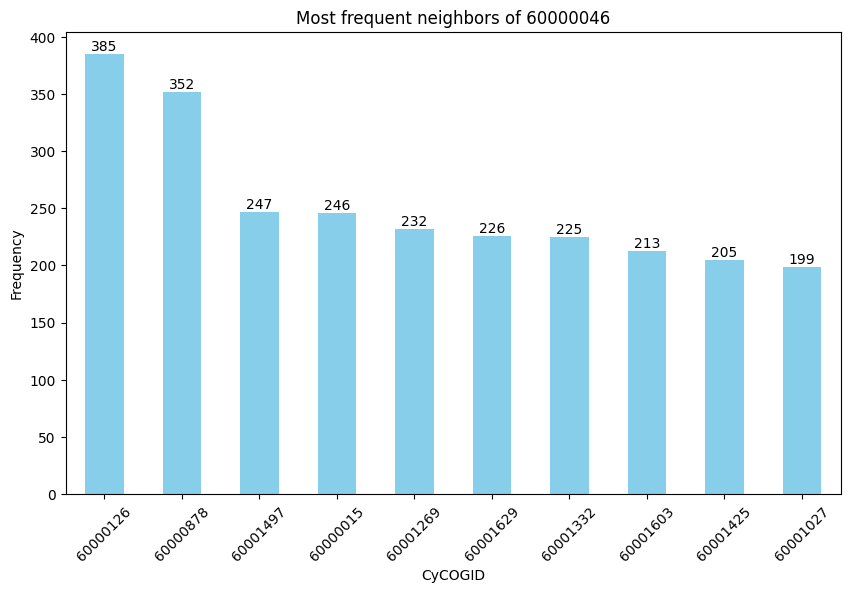

In [25]:
# plot common neighbors
cycogid_counts = finished_df['CyCOGID'].value_counts()

# Identify the top 10 most frequent CyCOGID values
top_10_cycogids = cycogid_counts.head(11)
top_10_cycogids = top_10_cycogids.iloc[1:] # removing the top frequency, which will be the reference cycog

# Filter the DataFrame to include only these top 10 CyCOGID values
top10s_df = finished_df[finished_df['CyCOGID'].isin(top_10_cycogids.index)]

# Plot the histogram
plt.figure(figsize=(10, 6))
ax = top10s_df['CyCOGID'].value_counts().reindex(top_10_cycogids.index).plot(kind='bar', color='skyblue')
plt.title(f'Most frequent neighbors of {refcycog}')
plt.xlabel('CyCOGID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()


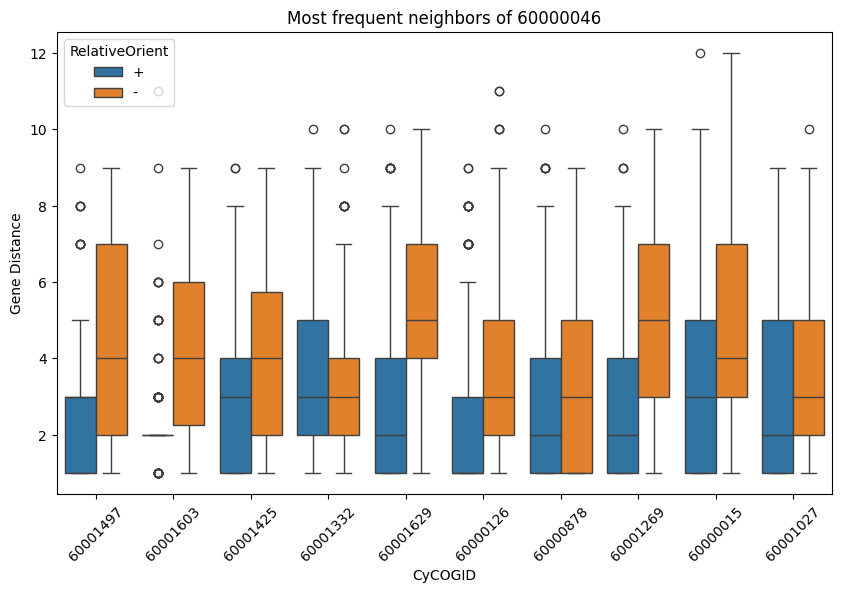

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=top10s_df, x="CyCOGID", y="GeneDistance", hue="RelativeOrient")

plt.title(f'Most frequent neighbors of {refcycog}')
plt.xlabel('CyCOGID')
plt.ylabel('Gene Distance')
plt.xticks(rotation=45)
plt.show()

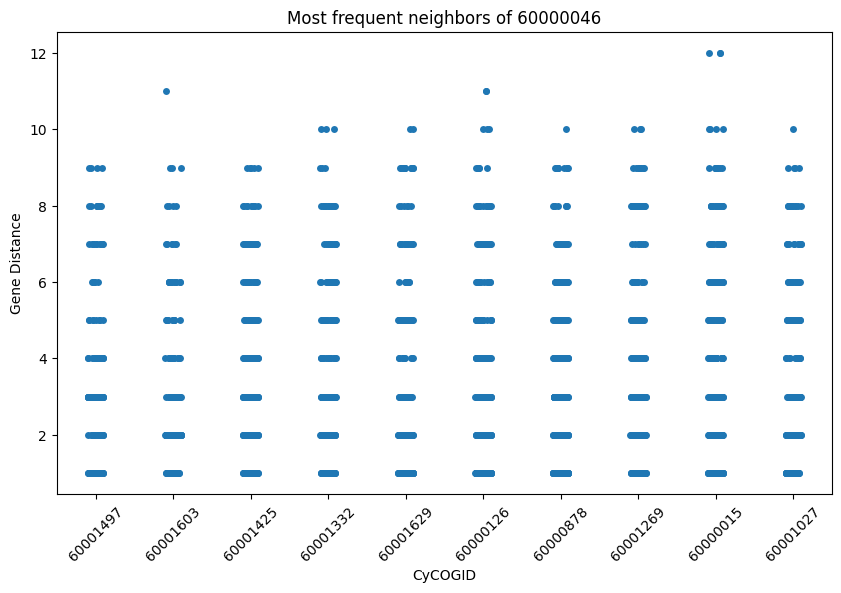

In [34]:

plt.figure(figsize=(10, 6))
sns.stripplot(data=top10s_df, x="CyCOGID", y="GeneDistance")

plt.title(f'Most frequent neighbors of {refcycog}')
plt.xlabel('CyCOGID')
plt.ylabel('Gene Distance')
plt.xticks(rotation=45)
plt.show()